In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../../lib")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import nengo
import h5py
import tqdm
import pyESN

In [5]:
with h5py.File("../../../data/generated/chapters/04_temporal_tuning/212fd1234166fc1b_spatio_temporal_network.h5", "r") as f:
    xs_train = f["xs_train"][()]
    xs_test = f["xs_test"][()]

In [6]:
def shift(xs, t, dt=1e-3):
    N = xs.shape[0]
    N_shift = int(t / dt)
    return np.concatenate((np.zeros(N_shift), xs))[:N]

In [7]:
xs_train_flt = nengo.Lowpass(100e-3).filtfilt(xs_train)
xs_test_flt = nengo.Lowpass(100e-3).filtfilt(xs_test)

In [8]:
def ddist_fast(xs, N_wnd=1000, dt=1e-3):
    N = xs.shape[0]
    res = np.zeros(N)
    ss = np.linalg.norm(xs, axis=1) * dt
    iss = np.cumsum(ss)
    return iss - np.concatenate((np.zeros(N_wnd), iss))[:N]

ds_train = ddist_fast(xs_train_flt)
ds_test = ddist_fast(xs_test_flt)

In [33]:
np.random.seed(5781)
ens = pyESN.ESN(n_inputs=2, n_outputs=1,
                n_reservoir=1000, teacher_forcing=True,
                spectral_radius=0.8)

In [34]:
ens.fit(xs_train_flt, shift(xs_train_flt[:, 0], 0.2))
xs_pred = ens.predict(xs_test_flt, continuation=False)

0.048487446966505525


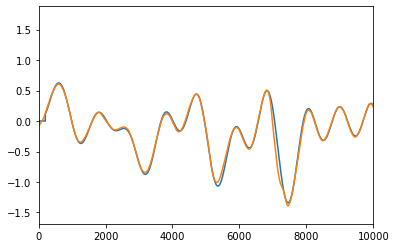

In [35]:
fig, ax = plt.subplots()
ax.plot(shift(xs_test_flt[:, 0], 0.2))
ax.plot(xs_pred)
ax.set_xlim(0, 10000)
print(np.sqrt(np.mean(np.square(xs_pred[:, 0] - shift(xs_test_flt[:, 0], 0.2)))))